---

## Simon's Algorithm

31 October 2024 (Happy Halloween)
<br>
Burton Rosenberg

---


In [1]:

import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, Pauli 
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from IPython.display import display, Math, HTML
import time, math
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

print(f'\nqiskit version: {qiskit.version.get_version_info()}\n')




qiskit version: 1.1.2



What is the power of a quantum computer? The Bernstein-Vizirani algorithm really shows no advantage. 
In that algorithm, there was a black box evalutation of $r(x)= \langle x|r\rangle$ (over $\mathbb{F}^n$), 
and BV could in one query determine $r$. This one query simultaneously evaluated $r(x)$ on all $x$. However,
the readout was on $n$ bits, and classically I could evalute $r(x)$ for $n$ specific $x$ reading one bit each
evaluation.

The Simon's problem is the following. A function $f:\{\,0,1\,\}^n\rightarrow\{\,0,1\,\}^n$ is 
on of types, 

- the identity
- of the form $\exists\, r\ne 0,\; \forall x,x'\,f(x)=f(x')  \iff x\oplus x'=r$.
- any other function.
  
The algorithm is to determine $r$ efficiently if it exists. The case of the identity is $r=0$. Let's promise that $f$
is one of the first two forms.

Here are two circuits which compute reversibly examples each of one of two classes. 

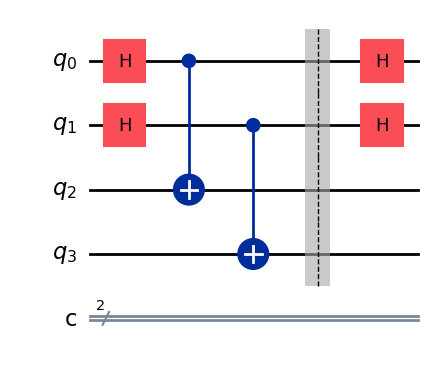

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

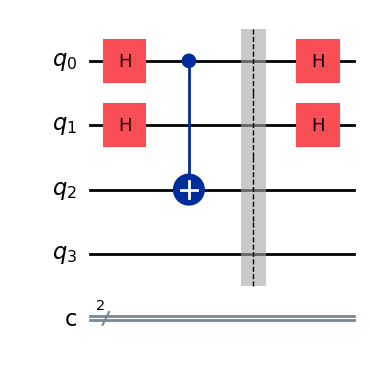

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [2]:
def bit_omit_function(n,omit=-1):
    qc = QuantumCircuit(2*n,n)
    for i in range(n):
        qc.h(i)
        if i!=omit:
            qc.cx(i,n+i)
    sv_before = Statevector(qc)
    qc.barrier()
    for i in range(n):
        qc.h(i)
    sv_after = Statevector(qc)
    return sv_before,sv_after,qc

def get_counts(qc):
    n = qc.num_clbits
    qc.measure(range(n),range(n))
    basic_sim = BasicSimulator()
    job = basic_sim.run(qc,shots=1024)
    result = job.result()
    return result.get_counts()

def my_display(sv_b,sv_a,qc,s):
    display(HTML(f'<p><b>{s}</b>'),qc.draw('mpl'))
    display(HTML('<p><b>before interference</b>'),sv_b.draw('latex'))
    display(HTML('<p><b>after interference</b>'),sv_a.draw('latex'))
    counts = get_counts(qc)
    display(HTML('<p><b>Sampling the wave function:</b><br>  '+ f'{counts}' +'</tt>'))

n = 2

sv_b,sv_a,qc= bit_omit_function(n)
my_display(sv_b,sv_a,qc,'identity function')
display(HTML('<p><hr><p>'))
sv_b,sv_a,qc= bit_omit_function(n,1)
my_display(sv_b,sv_a,qc,'bit projection function')


Consider a third circuit. This result, by now, you should be able to predict. But I put it here just to have it clear.

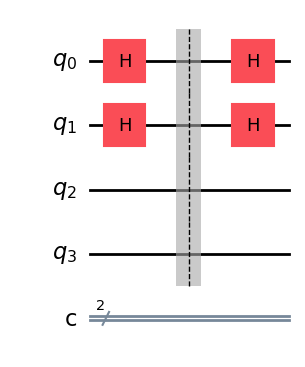

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
def null_function(n,omit=-1):
    qc = QuantumCircuit(2*n,n)
    for i in range(n):
        qc.h(i)
    sv_before = Statevector(qc)
    qc.barrier()
    for i in range(n):
        qc.h(i)
    sv_after = Statevector(qc)
    return sv_before,sv_after,qc

n = 2 
sv_b,sv_a,qc= null_function(n)
my_display(sv_b,sv_a,qc,'null function')

### Discussion

There are three circuits. One way to explain the result of the third circuit is to note $H\circ H=I$ and the tensor properties, to consider the result happening because the Hadamards cancel.

But why do they not cancel in the first and second circuits?

Instead, take the point of view that the Hadamard interferes the super-imposed calculations. In the third case there is cancelation of all but the $|00\ldots 0\rangle$ state. If the second circuit, the interference is completely ruined, so that all $2^n$ modes appear, but with postive and negative signs. 

And in the third case so interference occurs. Therefore immediately we see the posiblity sampling and statistically distinguishing between these two cases, and perhaps finding $r$.

And this is what Simon does, by post-processing the samples.

The statement is, when 
$$f_r(|x\,0^n\rangle\mapsto |y,f_r(x)\rangle$$ 
satifies the Simon Promise, and is not the identity, $r\ne 0$, then $\langle y|r\rangle = 0 $ is an identity.

If $f_r$ is the identity, $r=0$, only for $s=0$ is $\langle y|s\rangle=0$ an identity.

### Conclusion

We shall bruit force search of such $r$. But Simon notes that linear algebra can find a non-zero $r$ in the case $r=0$ with
only $O(n\log n)$ samples from the wave function. And in the case $r=0$, in that many samples enough outputs have been to 
span the $n$ dimensional space, proof postive that only $r=0$ is a solution.

Classically, it is a little easier to reason with a more broad Simon's Promise: either there is an $r\not =0$ such that
$f(x)=f(x') \iff x\oplus x'=r$ or $f$ is a permutation. For Simon's algorithm it does not mater that $f$ is a permutation 
rather than *the* identity permutation. In the case of a classical algorithm, we are given $f$ as an oracle with cost $O(1)$
for each query. 

In that case the function is not a permutation, it will take about an expected $O(\sqrt{2^n})$ queries to the oracle
to have a high probability of finding $x$ and $x'$ such that $f(x)=f(x')$.

In the case the function is a permutation, it will not be until $2^{n-1}$ queries are made to the oracle that 
we can be entirely sure that the function is a permutation.

### Subroutine Library

These are some routines that might be helpful in solving the exercises.


In [4]:
import itertools

def enum_01_gen(n):
    assert n>0
    t = []
    for i in itertools.product(range(2),repeat=n):
        yield ''.join(list(map(str,i)))

def e_string(n,i):
    return ''.join(['0'*i,'1','0'*(n-i-1)])

def xor_string(s,t):
    assert len(s)==len(t)
    r = ''
    for a,b in zip(s,t):
        c = '0'
        if a!=b:
            c = '1'
        r = c+r
    return r

def inner_product_strings(s,t):
    """
    returns the F_2^n inner product of s and t, where s and t are
    length n strings over the character set '0', '1'
    """
    assert len(s)==len(t)
    count = 0
    for a,b in zip(s,t):
        if a=='1' and b=='1':
            count += 1
    return count%2

def check_results_exhautive(s, counts):
    n = len(s)
    for y in enum_01_gen(n):
        b = inner_product_strings(y,s)
        if b==0 and y in counts:
            continue
        if b==1 and y not in counts:
            continue
        return False
    return True


test_library = False

if test_library:
    for i, s in enumerate(enum_01_gen(3)):
        print(i, s)
    n = 4
    for i in range(n):
        print(i, e_string(n,i))
    n = 3
    for i in range (n):
        for j in range (n):
            print(xor_string(e_string(n,i),e_string(n,j)))

### Exercise A

Verify this for the two circuits we have built:

- The circuit which copies every bit to the output,
- The circuit which copies all but one bit to the output.

Let $Y$ be the probably space of the measurements of the top $n$ qubits.

- In the first circuit for every $s$ except $s=0$ there is a $y\in Y,$ such that $\langle y|s\rangle\not=0$.
- In the second cicuit, besides $s=0$ there is exactly one other $s$ such that $\forall \,y\in Y,\,\langle y|s\rangle=0$.
- And in the case of the second circuit, this unique $s$ is such that $x\oplus x'=s$ exactly when $f(x)=f(x')$.



In [5]:
# answer to exercise A


            


### Exercise B

We have one Simon's Promise map. We look for another. Devise a map that maps 2-to-1 on the space and has an $r$ with Hamming weight of 2 (has exactly two 1's).

Predict which $s$ is is perpendictular to exactly the measured outputs, $y$. Then test this.

That is, check for your predicted $s$,
$$
\langle s|y\rangle= \begin{cases} 0 & y\in Y\\
1 & y \not\in Y
\end{cases}
$$

If you wish, prove for this circuit $s$ is unique among non-zero vectors that satisfies this condition.

In [6]:
# answer to exercise B

def two_xor_function(n,a,b):
    assert k!=j
    qc = QuantumCircuit(2*n,n)
    for i in range(n):
        qc.h(i)

    
    # code here

    
    sv_before = Statevector(qc)
    qc.barrier()
    for i in range(n):
        qc.h(i)
    sv_after = Statevector(qc)
    return sv_before,sv_after,qc

n, a, b = 4, 0, 1
sv_b, sv_a, qc = two_xor_function(n,a,b)
display(qc.draw('mpl'))
counts = get_counts(qc)
print(f'j: {j}, k: {k},\n\tcounts: {counts}')
s = '0011'
print(f'checking against vector {s}: {check_results_exhautive(s, counts)}')



NameError: name 'k' is not defined

### Exercise C

As Exercise B, but for $s$ of Hamming weight 3, that is, having exacly 3 ones.


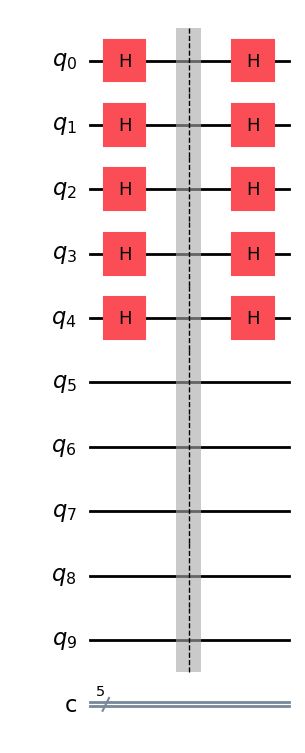

a: 0, b: 1, c: 2,
	counts: {'00000': 1024}
checking against vector 00111: False


In [7]:
# Answer to exercise C

# for weight 3 it is (a,b,c)->(a+c, b+c, 0)

def three_xor_function(n,a,b,c):
    qc = QuantumCircuit(2*n,n)
    for i in range(n):
        qc.h(i)

    
    # code here


    sv_before = Statevector(qc)
    qc.barrier()
    for i in range(n):
        qc.h(i)
    sv_after = Statevector(qc)
    return sv_before,sv_after,qc

n, a, b, c = 5, 0, 1, 2
sv_b, sv_a, qc = three_xor_function(n,a,b,c)
display(qc.draw('mpl'))
counts = get_counts(qc)
print(f'a: {a}, b: {b}, c: {c},\n\tcounts: {counts}')
s = '00111'
print(f'checking against vector {s}: {check_results_exhautive(s, counts)}')


### Exercise D

What is the construction for an arbitrary $s$?


#### Write your answer in math:

$$
i\hbar \frac{d}{dt}|\Psi\rangle = \hat{H}|\Psi\rangle
$$

#### Code your answer in python:

In [ ]:
#### code your answer in python



---
### END
----